# Program Evaluation and Review Technique (PERT) Analysis using Python

Author: Dr. J. Gopsill

Project Evaluation and Review Techniques (PERT) are methods of analysing the tasks involved in completing a given project, especially the time needed to complete each task, to identify the minimum time needed to complete the project. It can be considered to be a sub-section of graph theory where the aim is to identify the critical paths between tasks.

It incorporates uncertainty by making it possible to schedule a project while not knowing precisely the details and durations of all the activities. It is more of an event-oriented technique rather than start/completion oriented, and is used more in projects where time is the major factor rather than cost. It has been applied to many large-scale, one-time, complex, non-routine infrastructure and Research & Development projects.

PERT involves the generation of a graph where the vertices refer to tasks and the edges represent dependencies between the tasks. In contrast to critical path methods (CPM), where the edges would be weighted by a single metric, PERT applies three metrics for the time it will take for an activity to complete. PERT defines four types of time relating to an activity.

- **Optimistic** The minimum possible time required to accomplish an activity ($o$) or a path ($O$), assuming everything proceeds better than is normally expected.
- **Pessimistic** The maximum possible time required to accomplish an activity ($p$) or a path ($P$), assuming everything goes wrong (but excluding major catastrophes).
- **Most Likely Time** The best estimate of the time required to accomplish an activity ($m$) or a path ($M$), assuming everything proceeds as normal.
- **Expected Time** The best estimate of the time required to accomplish an activity ($e$) or a path ($E$), which is derived from the previous time estimates using Equation 1. % accounting for the fact that things don't always proceed as normal (the implication being that the expected time is the average time the task would require if the task were repeated on a number of occasions over an extended period of time).

$$
 e = \frac{o+4m+p}{6} (1)
$$

One can also calculate the standard deviation for the expected time based on $o$ and $p$.

$$
  \sigma_e = \frac{p-o}{6} (2)
$$

With these metrics and the activity graph, we are then able to determine:


- **Float (Slack)** This a measure of the excess time and resources available to complete a task. It is the amount of time that a project task can be delayed without causing a delay in any subsequent tasks (free float) or the whole project (total float). Positive float would indicate ahead of schedule; negative float would indicate behind schedule; and zero float would indicate on schedule.
- **Critical Path** The longest possible continuous pathway taken from the initial event to the terminal event. It determines the total calendar time required for the project; and, therefore, any time delays along the critical path will delay the reaching of the terminal event by at least the same amount.
- **Critical Activity** An activity that has total float equal to zero. An activity with zero float is not necessarily on the critical path since its path may not be the longest.
- **Lead time** The time by which a predecessor event must be completed in order to allow sufficient time for the activities that must elapse before a specific PERT event reaches completion.
- **Lag time** The earliest time by which a successor event can follow a specific PERT event.
- **Fast Tracking** Performing critical activities in parallel.
- **Crashing Critical Path** Shortening duration of critical activities.

In this python notebook, we will perform a PERT analysis on the project outlined in the Table 1 and can be found in the accompanying [data.csv](./data.csv)

| Activity | Predecessor | $o$ | $m$ | $e$ |
|------|------|------|------|
| SOP | | 2 | 4 | 6 |
| A | SOP | 2 | 4 | 6 |
| B | SOP | 3 | 5 | 9 |
| C | A | 4 | 5 | 7 |
| D | A | 4 | 6 | 10 |
| E | B, C | 4 | 5 | 7 |
| F | D | 3 | 4 | 8 |
| G | E | 3 | 5 | 8 |
| EOP | G, F | 0 | 0 | 0 |

If you find this tutorial useful then please cite this page in your work and/or buy me a coffee.

## Tutorial

The first thing we need to do is load up the relevant packages.

In [41]:
# A line of code that jupyter notebook uses to plot the images inline with the code and text
%matplotlib inline
# Custom settings for the python notebook to save images as svg rather than png
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib.pyplot as plt # for plotting
import networkx as nx # for analysing the network
import pprint # for pretty printing of variables
import csv # for loading in the data
pp = pprint.PrettyPrinter(indent=2)

## Creating the activities

The first thing we have to do is load in the data for our analysis. 

In [42]:
activities = []

with open('data.csv', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in csvreader:
        activities.append({
            'id': row[0],
            'deps': row[1].split(','),
            'o': float(row[2]),
            'm': float(row[3]),
            'p': float(row[4])
        })

pp.pprint(activities)

[ {'deps': [''], 'id': 'SOP', 'm': 0.0, 'o': 0.0, 'p': 0.0},
  {'deps': ['SOP'], 'id': 'A', 'm': 4.0, 'o': 2.0, 'p': 6.0},
  {'deps': ['SOP'], 'id': 'B', 'm': 5.0, 'o': 3.0, 'p': 9.0},
  {'deps': ['A'], 'id': 'C', 'm': 5.0, 'o': 4.0, 'p': 7.0},
  {'deps': ['A'], 'id': 'D', 'm': 6.0, 'o': 4.0, 'p': 10.0},
  {'deps': ['B', 'C'], 'id': 'E', 'm': 5.0, 'o': 4.0, 'p': 7.0},
  {'deps': ['D'], 'id': 'F', 'm': 4.0, 'o': 3.0, 'p': 8.0},
  {'deps': ['E'], 'id': 'G', 'm': 5.0, 'o': 3.0, 'p': 8.0},
  {'deps': ['G', 'F'], 'id': 'EOP', 'm': 0.0, 'o': 0.0, 'p': 0.0}]


## Creating the Directed Graph

To create the graph that will contain our activities, we simply call:

In [43]:
g = nx.DiGraph()

## Adding the vertices

The next step is to create all the vertices in the graph with the following attributes:

- Task name
- Expected Time ($e$)
- Early start time ($ES$)
- Early finish time ($EF$)
- Late start time ($LS$)
- Late finish time ($LF$)
- Float

In [44]:
# Create the vertices
for activity in activities:
    # Calculate the expected activity time
    e = float( (activity['o']+4*activity['m']+activity['p']) / 6)
    # Create the activity vertex
    g.add_node(
        activity['id'],
        o=activity['o'],
        m=activity['m'],
        p=activity['p'],
        e=e,
        es=0.,
        ef=0.,
        ls=1000., # Creating placeholder large values that are beyond the length of the project
        lf=1000.,
        f=0.,
        color='yellow'
    )

print('Number of Vertices:', g.number_of_nodes())

Number of Vertices: 9


## Adding the Edges

We then run through each activity and create edges to their dependencies.

In [45]:
for activity in activities:
    for dep in activity['deps']:
        if dep:
            print('From:', dep, 'To:', activity['id'])
            g.add_edge(dep, activity['id'], weight=0.)

print('---')
print('Number of Edges:', g.number_of_edges())

From: SOP To: A
From: SOP To: B
From: A To: C
From: A To: D
From: B To: E
From: C To: E
From: D To: F
From: E To: G
From: G To: EOP
From: F To: EOP
---
Number of Edges: 10


## Initial Plot

Now we can plot the results to check we have linked the vertices correctly.

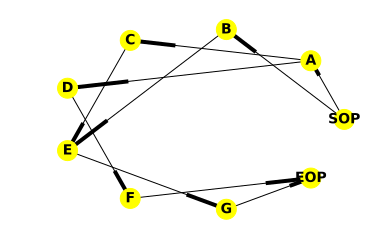

In [46]:
pos = nx.circular_layout(g)
node_colors = []
for v, d in g.nodes(data=True):
    node_colors.append(d['color'])
    
nx.draw_networkx(g, 
                 node_size=400,
                 with_labels=True,
                 pos=pos,
                 node_color=node_colors,
                 font_size='14',
                 font_weight='bold'
                )

plt.axis('off')
plt.show()

## Performing PERT Analysis

With the graph set-up, we can start to analyse the project and determine the critical activities and paths. This involves a 3 step process of:

1. Calculating the Early Start (ES) and Early Finish (EF)
2. Calculating the Late Start (ES), Late Finish (EF) and Float
3. Determining Critical Activities and Path


### Step 1. Calculating the Early Start (ES) and Early Finish (EF)

Step 1 is to calculate the Early Start ($ES$) and Early Finish ($EF$) times for each vertex. $ES$ is defined as the maximum $EF$ of all predecessor activities, unless the activity in question is the first activity, for which $ES=0$. EF is ES plus the expected task duration ($e$).

$$
  EF = ES + e
$$

In [47]:
vertices_to_check = ['SOP']

while vertices_to_check:
    print('--')
    print(vertices_to_check)
    next_vertices_to_check = []
    
    for start_v in vertices_to_check:
        for end_v in g.successors(start_v):
            
            es = g.node[start_v]['ef']
            ef = g.node[start_v]['ef'] + g.node[end_v]['e']
            
            print(start_v, end_v, es, ef)
            
            # if the calculated es is greater than or equal to values that have come before it 
            # (may have reached this vertex before through a different path)
            if (es >= g.node[end_v]['es']):
                g.node[end_v]['es'] = es
                g.node[end_v]['ef'] = ef
                next_vertices_to_check.append(end_v)
    
    next_vertices_to_check = list(set(next_vertices_to_check))
    vertices_to_check = next_vertices_to_check



--
['SOP']
SOP A 0.0 4.0
SOP B 0.0 5.333333333333333
--
['B', 'A']
B E 5.333333333333333 10.5
A C 4.0 9.166666666666668
A D 4.0 10.333333333333332
--
['D', 'C', 'E']
D F 10.333333333333332 14.833333333333332
C E 9.166666666666668 14.333333333333336
E G 14.333333333333336 19.500000000000004
--
['G', 'F', 'E']
G EOP 19.500000000000004 19.500000000000004
F EOP 14.833333333333332 14.833333333333332
E G 14.333333333333336 19.500000000000004
--
['EOP', 'G']
G EOP 19.500000000000004 19.500000000000004
--
['EOP']


## Step 2. Calculating the Late Start (ES), Late Finish (EF) and Float

If everything runs smoothly, the project should take 19.51 work days to complete. With this information, we can work backwards to determine the Late Start ($LS$) and Late Finish ($LF$) times for each task. $LF$ is defined as the minimum $LS$ of all successor activities, unless the activity is the last activity, for which the $LF=EF$. The $LS$ is the $LF$ minus the task duration.

$$
LS = LF - e
$$

In [48]:
# Clean up the EOP vertex
g.node['EOP']['lf'] = g.node['EOP']['es']
g.node['EOP']['ls'] = g.node['EOP']['es']

vertices_to_check = ['EOP']

while vertices_to_check:
    print('--')
    print(vertices_to_check)
    next_vertices_to_check = []
    
    for end_v in vertices_to_check:
        for start_v in g.predecessors(end_v):
            lf = g.node[end_v]['ls']
            ls = lf - g.node[start_v]['e']
            f = lf - g.node[start_v]['ef']
            print(end_v, start_v, lf, ls, f)
            # if the calculated es is greater than or equal to values that have come before it 
            # (may have reached this vertex before through a different path)
            if (ls <= g.node[start_v]['ls']):
                g.node[start_v]['ls'] = ls
                g.node[start_v]['lf'] = lf
                g.node[start_v]['f'] = f
                next_vertices_to_check.append(start_v)
    
    next_vertices_to_check = list(set(next_vertices_to_check))
    print('Next to check:', next_vertices_to_check)
    vertices_to_check = next_vertices_to_check

--
['EOP']
EOP G 19.500000000000004 14.333333333333336 0.0
EOP F 19.500000000000004 15.000000000000004 4.666666666666671
Next to check: ['F', 'G']
--
['F', 'G']
F D 15.000000000000004 8.666666666666671 4.666666666666671
G E 14.333333333333336 9.166666666666668 0.0
Next to check: ['D', 'E']
--
['D', 'E']
D A 8.666666666666671 4.666666666666671 4.666666666666671
E B 9.166666666666668 3.833333333333335 3.833333333333335
E C 9.166666666666668 4.000000000000001 0.0
Next to check: ['B', 'C', 'A']
--
['B', 'C', 'A']
B SOP 3.833333333333335 3.833333333333335 3.833333333333335
C A 4.000000000000001 8.881784197001252e-16 8.881784197001252e-16
A SOP 8.881784197001252e-16 8.881784197001252e-16 8.881784197001252e-16
Next to check: ['SOP', 'A']
--
['SOP', 'A']
A SOP 8.881784197001252e-16 8.881784197001252e-16 8.881784197001252e-16
Next to check: ['SOP']
--
['SOP']
Next to check: []


## Step 3. Determining Critical Activities and Path

Having calculated $LS$ and $LF$ for each task, we can calculate the float for each activity. Float is equal to $LF - EF$ or $LS - ES$ as these are equivalent. This enables us to identify the critical path activities, which are indicated by the task having zero float.

In [49]:
for v, d in g.nodes(data=True):
    # threshold accounting for numerical error
    if d['f'] < 0.01:
        g.node[v]['color'] = 'magenta'
        pp.pprint(v)

'SOP'
'A'
'C'
'E'
'G'
'EOP'


This can then be plotted to show the activities in the graph

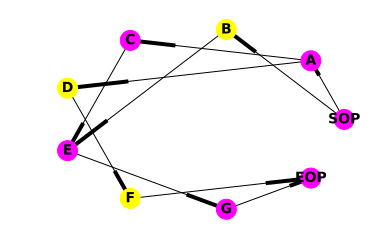

In [50]:
pos = nx.circular_layout(g)
node_colors = []
for v, d in g.nodes(data=True):
    node_colors.append(d['color'])
    
nx.draw_networkx(g, 
                 node_size=400,
                 with_labels=True,
                 pos=pos,
                 node_color=node_colors,
                 font_size='14',
                 font_weight='bold'
                )

plt.axis('off')
plt.show()

To determine the critical path, we simply translate the float of the nodes to the edges linking them to their successors and run the shortest path algorithm to find the path between SOP and EOP.

In [51]:
for u, d in g.nodes(data=True):
    for v in g.successors(u):
        g[u][v]['weight'] = d['f']
        
print(nx.shortest_path(g, source='SOP', target='EOP', weight='weight'))

['SOP', 'A', 'C', 'E', 'G', 'EOP']


And there we have it, the basics of a PERT analysis performed in Python and is as far as we will go in the notebook. However, there is much more analysis that can be performed using this graph to provide organisations more information on the potential risk within the project. One example is the ability to automate the generation of these values so that you can perform a Monte-Carlo simulation based on the time distributions (known as PERT-beta distributions). This analysis can provide insights in the potential variance in the critical path and the likelihood of the path changing depending on the task times.

More advanced PERT analysis also enables the inclusion of resource constraints, which limit the number of concurrent tasks. This could be due to a limitation in the availability of labour, machines and/or costed time.

I am hoping to provide some more advanced PERT tutorials in the future so watch this space.